In [37]:
import pandas as pd
import json
import numpy as np


from imagedata_NeoroScan import medical_train, medical_test, display_img
from image_loading import * 
print("All Prerequisites Loaded Successfully")

All Prerequisites Loaded Successfully


In [38]:
print("Medical Training Sets =",len(medical_train))
print("Medical Testing Sets =",len(medical_test))

Medical Training Sets = 4
Medical Testing Sets = 4


In [39]:
print("Structure of Training Images :")
str_training = structure_img(medical_train)

Structure of Training Images :
Type: <class 'list'>
Lenght: 4
  Type: <class 'list'>
  Lenght: 3157
    Type: <class 'PIL.Image.Image'>


In [40]:
print("Structure of Testing Images :")
str_testing = structure_img(medical_test)

Structure of Testing Images :
Type: <class 'list'>
Lenght: 4
  Type: <class 'list'>
  Lenght: 136
    Type: <class 'PIL.Image.Image'>


Training Images...


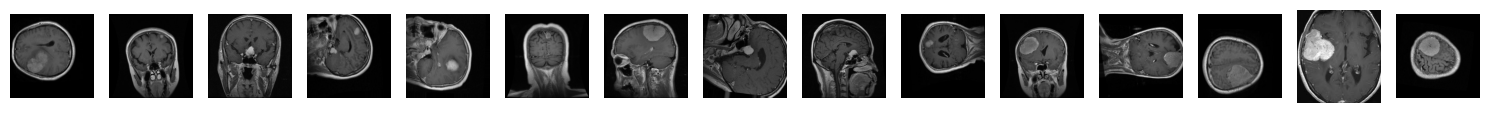

In [41]:
print("Training Images...")
train_image = display_img(medical_train, 0, 15)

Testing Images...


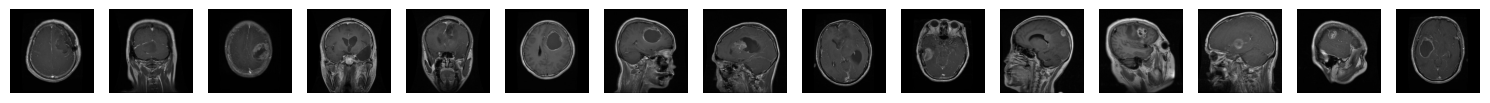

In [42]:
print("Testing Images...")
test_image = display_img(medical_test, 0, 15)


In [43]:
import torch, torchvision.transforms as T
from torchvision import models

model = models.resnet50(pretrained = True)
model = torch.nn.Sequential(*list(model.children()))[:-1]

C:\Users\Tanmay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Tanmay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
for img_var in medical_train:
    print("vectorising train set...")
    print("="*20)
    vector_train = []

    for img in img_var[:200]:
        
       
        prep = prep = T.Compose([T.Resize((256,256)), T.CenterCrop((224,224)),T.Grayscale(num_output_channels= 3), T.ToTensor()])
        tensor = prep(img).unsqueeze(0)

        vector_tr = model(tensor)

vectorising train set...
vectorising train set...
vectorising train set...
vectorising train set...


In [45]:
for img_var in medical_test:
    print("vectorising test set...")
    print("="*20)
    vector_test = []

    for img in img_var[:200]:
        prep = T.Compose([T.Resize((256,256)), T.CenterCrop((224,224)),T.Grayscale(num_output_channels= 3), T.ToTensor()])
        tensor = prep(img).unsqueeze(0)

        vector_ts = model(tensor)

vectorising test set...
vectorising test set...
vectorising test set...
vectorising test set...


In [46]:
print("Vectorized Training Set:", vector_tr, sep ="\n")
print(type(vector_tr))

x_tr = vector_tr.view(vector_tr.size(0), -1)
x_ts = vector_ts.view(vector_ts.size(0), -1)

Vectorized Training Set:
tensor([[[[0.3265]],

         [[0.5237]],

         [[0.4463]],

         ...,

         [[0.3179]],

         [[0.4874]],

         [[0.3135]]]], grad_fn=<MeanBackward1>)
<class 'torch.Tensor'>


In [48]:
y_tr = np.zeros(x_tr.shape[0], dtype= int)
y_ts = np.zeros(x_ts.shape[0], dtype= int)

In [53]:
import pandas as pd
import numpy as np
import torch

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x 

x_tr = to_numpy(x_tr)
x_ts = to_numpy(x_ts)
y_tr = to_numpy(y_tr)
y_ts = to_numpy(y_ts)

feature_cols = [f"feat_{i}" for i in range(x_tr.shape[1])]
print(f"Feature Columns: {len(feature_cols)}")

df_1 = pd.DataFrame(x_tr, columns = feature_cols)
df_1["labels"] = y_tr
df_1["split"] = "train"

df_2 = pd.DataFrame(x_ts, columns = feature_cols)
df_2["labels"] = y_ts
df_2["split"] = "test"

df = pd.concat([df_1, df_2], ignore_index= True)
print(df.head())
print(df["split"].value_counts())








Feature Columns: 2048
     feat_0    feat_1    feat_2    feat_3    feat_4    feat_5    feat_6  \
0  0.326502  0.523656  0.446253  0.398547  0.537282  0.526137  0.491680   
1  0.391730  0.526088  0.526207  0.370039  0.574461  0.557378  0.492022   

     feat_7    feat_8    feat_9  ...  feat_2040  feat_2041  feat_2042  \
0  0.493327  0.441357  0.436572  ...   0.442514   0.377806   0.420250   
1  0.460746  0.440959  0.401171  ...   0.430256   0.426530   0.447638   

   feat_2043  feat_2044  feat_2045  feat_2046  feat_2047  labels  split  
0   0.188733   0.403240   0.317930   0.487429   0.313506       0  train  
1   0.183841   0.490627   0.364798   0.476493   0.364989       0   test  

[2 rows x 2050 columns]
split
train    1
test     1
Name: count, dtype: int64


In [54]:
print("Vectorized Testing Set:", vector_ts, sep="\n")
print(type(vector_ts))


Vectorized Testing Set:
tensor([[[[0.3917]],

         [[0.5261]],

         [[0.5262]],

         ...,

         [[0.3648]],

         [[0.4765]],

         [[0.3650]]]], grad_fn=<MeanBackward1>)
<class 'torch.Tensor'>


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

x_train = df[df.split == "train"].drop(columns=["labels","split"]).values
y_train = df[df.split == "train"]["labels"].values

x_test = df[df.split == "test"].drop(columns=["labels" , "split"]).values
y_test = df[df.split == "test"]["labels"].values

rf = RandomForestClassifier(
    n_estimators= 200,
    random_state=42
)

rf.fit(x_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
x_train

In [56]:
df.loc[df.sample(frac=0.2 , random_state = 42).index, "split"] = "test"

x_test = df[df.split == "test"].drop(columns = ["labels", "split"]).values
y_test = df[df.split == "test"]["labels"].values

In [57]:
x_test

array([[0.39173007, 0.52608824, 0.52620727, ..., 0.3647975 , 0.47649312,
        0.36498925]], shape=(1, 2048), dtype=float32)

In [61]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

y_pred = rf.predict(x_test)
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_pred, y_test))

Accuracy: 1.0
Precision: 0.0


C:\Users\Tanmay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [58]:
from sklearn.cluster import KMeans as km

kmeans = km(
    n_clusters= 1,
    random_state= 42,
    max_iter= 300,
    
)

print("Model Type Info :: ", type(kmeans))
print("Model Description ::", kmeans)

Model Type Info ::  <class 'sklearn.cluster._kmeans.KMeans'>
Model Description :: KMeans(n_clusters=1, random_state=42)


In [ ]:
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
print("Vectorised Data's Type", sep="/n")
print(type(vector_tr), type(vector_ts))
print("Vectorised Data's Shape", sep="/n")
print("Training Value =",vector_tr.shape,"Testing Value =", vector_ts.shape )
print("Vectorised Data's Unsqueezed Shape ", sep="/n")
print("Training UnSqueezed =", vector_tr.unsqueeze(0).shape, "Testing Unsqueezed =", vector_ts.unsqueeze(0).shape)


Vectorised Data's Type
<class 'torch.Tensor'> <class 'torch.Tensor'>
Vectorised Data's Shape
Training Value = torch.Size([1, 2048, 1, 1]) Testing Value = torch.Size([1, 2048, 1, 1])
Vectorised Data's Unsqueezed Shape 
Training UnSqueezed = torch.Size([1, 1, 2048, 1, 1]) Testing Unsqueezed = torch.Size([1, 1, 2048, 1, 1])


In [ ]:
print("Structure of Vector Train :")
str_training_v = structure_img(vector_tr)

print("Structure of Vector Testing :")
str_testing_v = structure_img(vector_ts)

Structure of Vector Train :
Type: <class 'torch.Tensor'>
Structure of Vector Testing :
Type: <class 'torch.Tensor'>


In [ ]:
x_tr = (vector_tr.view(vector_tr.size(0), -1)).detach().cpu().numpy()
x_ts = (vector_ts.view(vector_ts.size(0), -1)).detach().cpu().numpy()

y_tr = torch.tensor([0] * x_tr.shape[0]).detach().cpu().numpy()
y_ts = torch.tensor([1] * x_tr.shape[0]).detach().cpu().numpy()

training_material = x_tr , x_ts, y_tr, y_ts
print(training_material)

(array([[0.32650167, 0.52365565, 0.44625306, ..., 0.31793007, 0.48742867,
        0.31350648]], shape=(1, 2048), dtype=float32), array([[0.39173007, 0.52608824, 0.52620727, ..., 0.3647975 , 0.47649312,
        0.36498925]], shape=(1, 2048), dtype=float32), array([0]), array([1]))


In [ ]:
y_tr = torch.as_tensor(y_tr)
y_ts = torch.as_tensor(y_ts)

y = torch.cat([y_tr,y_ts],dim = 0)
y = y.detach().cpu().numpy()



In [ ]:
print("X_train:", x_tr)
print("x_test:",x_ts)
print("y_train:",y_tr)
print("y_test:",y_ts)

X_train: [[0.32650167 0.52365565 0.44625306 ... 0.31793007 0.48742867 0.31350648]]
x_test: [[0.39173007 0.52608824 0.52620727 ... 0.3647975  0.47649312 0.36498925]]
y_train: tensor([0])
y_test: tensor([1])


In [ ]:
kmeans_x_cluster = vector_tr.view(vector_tr.size(0), -1)
kmeans_x_cluster


tensor([[0.3265, 0.5237, 0.4463,  ..., 0.3179, 0.4874, 0.3135]],
       grad_fn=<ViewBackward0>)

In [ ]:
print("="*20)
print("Model Training ...")
print("="*20)
cluster = kmeans.fit_predict(kmeans_x_cluster.detach().cpu().numpy())
print(cluster)

Model Training ...


[0]


In [ ]:
# y_pred = rfc.predict(x_ts)
# print("Y_prediction :", y_pred)


In [ ]:
# from sklearn.metrics import accuracy_score, precision_score , f1_score, recall_score

# accuracy = accuracy_score(y_pred, y_ts)
# precision = precision_score(y_pred, y_ts)
# f_1 = f1_score(y_pred, y_ts)
# recall = recall_score(y_pred, y_ts)


